# Find IT UGM - ODE 

## Import Library

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from IPython.display import display

# Model Library
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier, Pool, cv
import optuna

from xgboost import XGBClassifier

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from category_encoders import OrdinalEncoder as oe

# custom plot seaborn
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, palette='tab10')

np.random.seed(5)
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Import Custom Classes / Function

In [5]:
from model import RandomForest

## Data Preparation + Cleansing

### Features

`h1n1_concern` - Level of concern about the H1N1 flu.
0 = Not at all concerned; 1 = Not very concerned; 2 = Somewhat concerned; 3 = Very concerned.

`h1n1_knowledge` - Level of knowledge about H1N1 flu.
0 = No knowledge; 1 = A little knowledge; 2 = A lot of knowledge.

`behavioral_antiviral_meds` - Has taken antiviral medications. (binary)

`behavioral_avoidance` - Has avoided close contact with others with flu-like symptoms. (binary)

`behavioral_face_mask` - Has bought a face mask. (binary)

`behavioral_wash_hands` - Has frequently washed hands or used hand sanitizer. (binary)

`behavioral_large_gatherings` - Has reduced time at large gatherings. (binary)

`behavioral_outside_home` - Has reduced contact with people outside of own household. (binary)

`behavioral_touch_face` - Has avoided touching eyes, nose, or mouth. (binary)

`doctor_recc_h1n1` - H1N1 flu vaccine was recommended by doctor. (binary)

`doctor_recc_seasonal` - Seasonal flu vaccine was recommended by doctor. (binary)

`chronic_med_condition` - Has any of the following chronic medical conditions: asthma or an other lung condition, diabetes, a heart condition, a kidney condition, sickle cell anemia or other anemia, a neurological or neuromuscular condition, a liver condition, or a weakened immune system caused by a chronic illness or by medicines taken for a chronic illness. (binary)

`child_under_6_months` - Has regular close contact with a child under the age of six months. (binary)

`health_worker` - Is a healthcare worker. (binary)

`health_insurance` - Has health insurance. (binary)

`opinion_h1n1_vacc_effective` - Respondent's opinion about H1N1 vaccine effectiveness.
1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.

`opinion_h1n1_risk` - Respondent's opinion about risk of getting sick with H1N1 flu without vaccine.
1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.

`opinion_h1n1_sick_from_vacc` - Respondent's worry of getting sick from taking H1N1 vaccine.
1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.

`opinion_seas_vacc_effective` - Respondent's opinion about seasonal flu vaccine effectiveness.
1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.

`opinion_seas_risk` - Respondent's opinion about risk of getting sick with seasonal flu without vaccine.
1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.

`opinion_seas_sick_from_vacc` - Respondent's worry of getting sick from taking seasonal flu vaccine.
1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.

`age_group` - Age group of respondent.

`education` - Self-reported education level.

`race` - Race of respondent.

`sex` - Sex of respondent.

`income_poverty` - Household annual income of respondent with respect to 2008 Census poverty thresholds.

`marital_status` - Marital status of respondent.

`rent_or_own` - Housing situation of respondent.

`employment_status` - Employment status of respondent.

`hhs_geo_region` - Respondent's residence using a 10-region geographic classification defined by the U.S. Dept. of Health and Human Services. Values are represented as short random character strings.

`census_msa` - Respondent's residence within metropolitan statistical areas (MSA) as defined by the U.S. Census.

`household_adults` - Number of other adults in household, top-coded to 3.

`household_children` - Number of children in household, top-coded to 3.

`employment_industry` - Type of industry respondent is employed in. Values are represented as short random character strings.

`employment_occupation` - Type of occupation of respondent. Values are represented as short random character strings.

### Target variables :
`h1n1_vaccine` - Whether respondent received H1N1 flu vaccine.

`seasonal_vaccine` - Whether respondent received seasonal flu vaccine.

Both are binary variables: 0 = No; 1 = Yes.

### Loading Data

In [198]:
df_features = pd.read_csv('data/training_set_features.csv', index_col="respondent_id")
df_labels = pd.read_csv('data/training_set_labels.csv', index_col="respondent_id")

df_test_features = pd.read_csv('data/test_set_features.csv', index_col="respondent_id")

In [199]:
df_labels.columns

Index(['h1n1_vaccine', 'seasonal_vaccine'], dtype='object')

In [200]:
df_features.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'],
      dtype='object')

In [201]:
df_test_features.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'],
      dtype='object')

### Handling null data

In [202]:
df_features.isna().sum()

h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
r

Features with null data: 

`h1n1_concern`                      92 - (0 = Not at all concerned; 1 = Not very concerned; 2 = Somewhat concerned; 3 = Very concerned.)

`h1n1_knowledge`                   116 - (0 = No knowledge; 1 = A little knowledge; 2 = A lot of knowledge.)

`behavioral_antiviral_meds`         71 - (binary)

`behavioral_avoidance`             208 - (binary)

`behavioral_face_mask`              19 - (binary)

`behavioral_wash_hands`             42 - (binary)

`behavioral_large_gatherings`       87 - (binary)

`behavioral_outside_home`           82 - (binary)

`behavioral_touch_face`            128 - (binary)

`doctor_recc_h1n1`                2160 - (binary)

`doctor_recc_seasonal`            2160 - (binary)

`chronic_med_condition`            971 - (binary)

`child_under_6_months`             820 - (binary)

`health_worker`                    804 - (binary)

`health_insurance`               12274 - (binary)

`opinion_h1n1_vacc_effective`      391 - (1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.)

`opinion_h1n1_risk`                388 - (1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.)

`opinion_h1n1_sick_from_vacc`      395 - (1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.)

`opinion_seas_vacc_effective`      462 - (1 = Not at all effective; 2 = Not very effective; 3 = Don't know; 4 = Somewhat effective; 5 = Very effective.)

`opinion_seas_risk`                514 - (1 = Very Low; 2 = Somewhat low; 3 = Don't know; 4 = Somewhat high; 5 = Very high.)

`opinion_seas_sick_from_vacc`      537 - (1 = Not at all worried; 2 = Not very worried; 3 = Don't know; 4 = Somewhat worried; 5 = Very worried.)

`education`                       1407 - ('< 12 Years', '12 Years', 'College Graduate', 'Some College')

`income_poverty`                  4423 - ('Below Poverty', '<= $75,000, Above Poverty', '> $75,000')

`marital_status`                  1408 - ('Not Married', 'Married')

`rent_or_own`                     2042 - ('own', 'rent')

`employment_status`               1463 - ('Not in Labor Force', 'Employed', 'Unemployed')

`household_adults`                 249 - (0, 1, 2, 3)

`household_children`               249 - (0, 1, 2, 3)

`employment_industry`            13330 - ('pxcmvdjn', 'rucpziij', 'wxleyezf', 'saaquncn', 'xicduogh','ldnlellj', 'wlfvacwt', 'nduyfdeo', 'fcxhlnwr', 'vjjrobsf','arjwrbjb', 'atmlpfrs', 'msuufmds', 'xqicxuve', 'phxvnwax','dotnnunm', 'mfikgejo', 'cfqqtusy', 'mcubkhph', 'haxffmxo', 'qnlwzans')

`employment_occupation`          13470 - ('xgwztkwe', 'xtkaffoo', 'emcorrxb', 'vlluhbov', 'xqwwgdyp', 'ccgxvspp', 'qxajmpny', 'kldqjyjy', 'mxkfnird', 'hfxkjkmi', 'bxpfxfdn', 'ukymxvdu', 'cmhcxjea', 'haliazsg', 'dlvbwzss', 'xzmlyyjv', 'oijqvulv', 'rcertsgn', 'tfqavkke', 'hodpvpew', 'uqqtjvyb', 'pvmttkik', 'dcjcmpih')

In [203]:
df_test_features.isna().sum()

h1n1_concern                      85
h1n1_knowledge                   122
behavioral_antiviral_meds         79
behavioral_avoidance             213
behavioral_face_mask              19
behavioral_wash_hands             40
behavioral_large_gatherings       72
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            932
child_under_6_months             813
health_worker                    789
health_insurance               12228
opinion_h1n1_vacc_effective      398
opinion_h1n1_risk                380
opinion_h1n1_sick_from_vacc      375
opinion_seas_vacc_effective      452
opinion_seas_risk                499
opinion_seas_sick_from_vacc      521
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4497
marital_status                  1442
r

In [204]:
df_labels.isna().sum()

h1n1_vaccine        0
seasonal_vaccine    0
dtype: int64

`df_labels` doesn't contain any null data, so null data cleaning will be done to `df_features` only

In [205]:
df_features["employment_occupation"].unique()

array([nan, 'xgwztkwe', 'xtkaffoo', 'emcorrxb', 'vlluhbov', 'xqwwgdyp',
       'ccgxvspp', 'qxajmpny', 'kldqjyjy', 'mxkfnird', 'hfxkjkmi',
       'bxpfxfdn', 'ukymxvdu', 'cmhcxjea', 'haliazsg', 'dlvbwzss',
       'xzmlyyjv', 'oijqvulv', 'rcertsgn', 'tfqavkke', 'hodpvpew',
       'uqqtjvyb', 'pvmttkik', 'dcjcmpih'], dtype=object)

In [206]:
df_features = pd.read_csv("data/training_set_features.csv")
df_test_features = pd.read_csv("data/test_set_features.csv")

#### Education columns

With the assumption that education is affected by sex and age group, education will be filled using RF on sex and age group columns

##### Train Data

In [207]:
age_group = pd.get_dummies(df_features["age_group"], prefix="age")
sex = pd.get_dummies(df_features["sex"], prefix="sex")

education = pd.concat([age_group, sex, df_features[["education"]]], axis=1)
education_train = education.dropna()
education_predict = education[education.isnull().any(axis=1)]

education_train_X = education_train[[*age_group.columns, *sex.columns]]
education_train_y = education_train[["education"]]

education_predict_X = education_predict[[*age_group.columns, *sex.columns]]

random_forest_model = RandomForest(education_train_X, education_train_y, education_predict_X, depth=4)
random_forest_model.fit()

education_predict["education"] = random_forest_model.predict()

df_features = df_features.fillna(education_predict[["education"]])

##### Test Data

In [208]:
age_group = pd.get_dummies(df_test_features["age_group"], prefix="age")
sex = pd.get_dummies(df_test_features["sex"], prefix="sex")

education = pd.concat([age_group, sex, df_test_features[["education"]]], axis=1)
education_train = education.dropna()
education_predict = education[education.isnull().any(axis=1)]

education_train_X = education_train[[*age_group.columns, *sex.columns]]
education_train_y = education_train[["education"]]

education_predict_X = education_predict[[*age_group.columns, *sex.columns]]

random_forest_model = RandomForest(education_train_X, education_train_y, education_predict_X, depth=4)
random_forest_model.fit()

education_predict["education"] = random_forest_model.predict()

df_test_features = df_test_features.fillna(education_predict[["education"]])

#### Employment Occupation and Industry Columns

In [209]:
df_features[["employment_occupation", "employment_industry", "employment_status"]].loc[(df_features["employment_status"] == "Unemployed") | (df_features["employment_status"] == "Not in Labor Force")].count()

employment_occupation        0
employment_industry          0
employment_status        11684
dtype: int64

NaN happened because the respondent is "Unemployed" or "Not in Labor" because of that, we can fill the NaN value with some specific value, such as "xxxxx"

In [210]:
df_features[["employment_occupation", "employment_industry"]] = df_features[["employment_occupation", "employment_industry"]].fillna("xxxxx")
df_test_features[["employment_occupation", "employment_industry"]] = df_test_features[["employment_occupation", "employment_industry"]].fillna("xxxxx")

#### Employment Status Columns

In [211]:
df_features[["employment_occupation", "employment_industry", "employment_status"]] .loc[(df_features["employment_status"].isna()) & ((df_features["employment_industry"]  != "xxxxx") | df_features["employment_occupation"]  != "xxxxx")].count()

employment_occupation    1463
employment_industry      1463
employment_status           0
dtype: int64

Because of above details, employment_status with NaN data will be filled with "Unemployed'

In [212]:
df_features[["employment_status"]] = df_features[["employment_status"]].fillna("Unemployed")
df_test_features[["employment_status"]] = df_features[["employment_status"]].fillna("Unemployed")

#### Other Columns

other features will be filled with the largest data / mode

In [213]:
df_features.fillna(df_features.mode().iloc[0], inplace=True)
df_test_features.fillna(df_test_features.mode().iloc[0], inplace=True)

<AxesSubplot:>

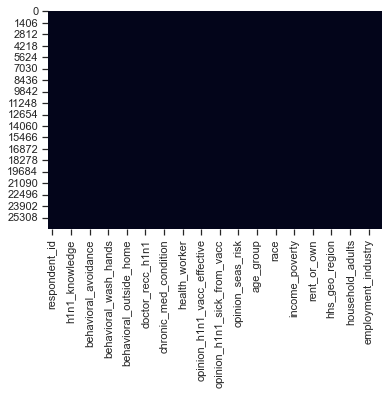

In [214]:
sns.heatmap(df_features.isnull(), cbar=False)

<AxesSubplot:>

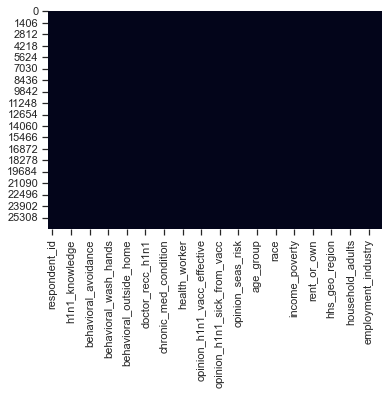

In [215]:
sns.heatmap(df_test_features.isnull(), cbar=False)

## EDA

In [22]:
# delete soon

df_features.select_dtypes(include=['int64', 'float64']).columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults',
       'household_children'],
      dtype='object')

In [23]:
# delete soon

df_features.select_dtypes(include=['object']).columns

Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation'],
      dtype='object')

Numeric

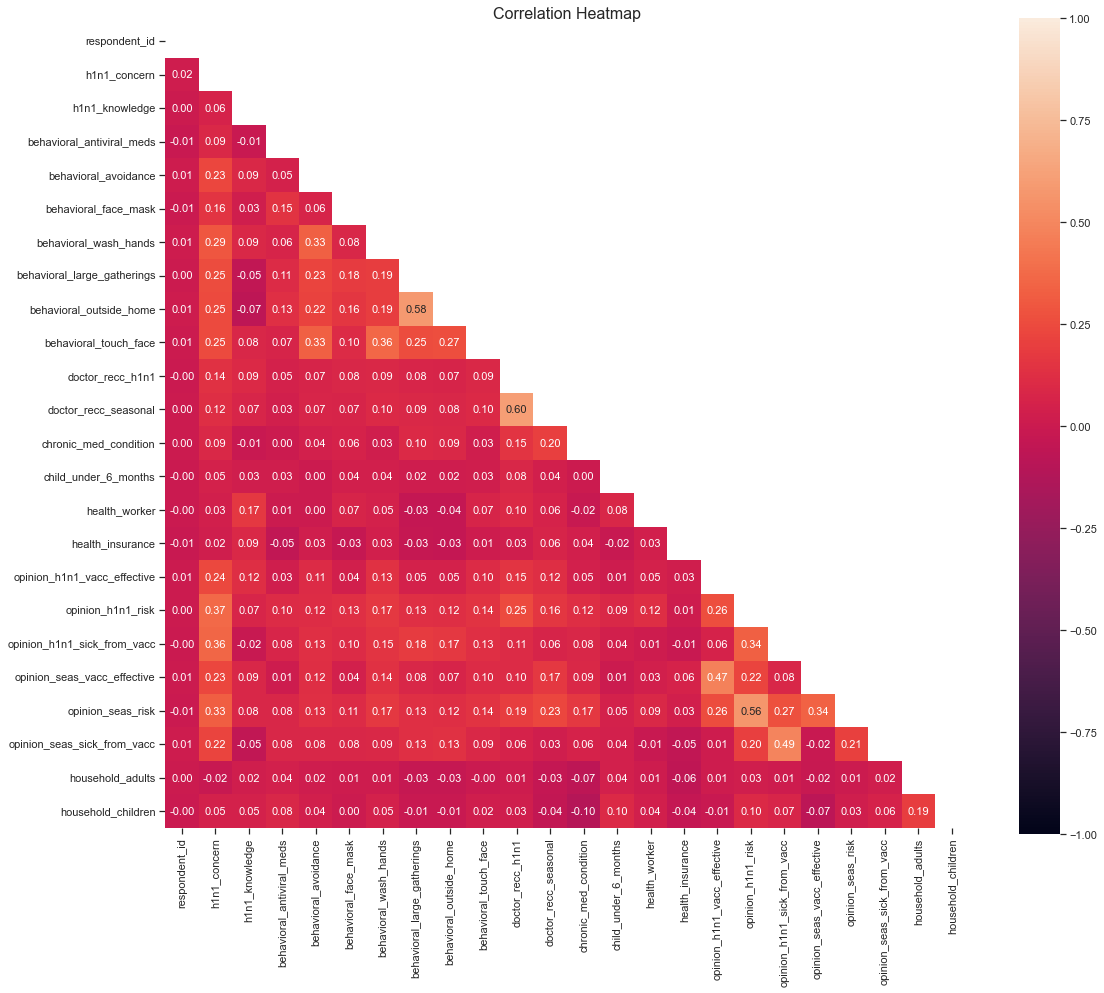

In [24]:
# correlation matrix

plt.figure(figsize=(18,15))

mask = np.triu(np.ones_like(df_features.corr(numeric_only=True), dtype=bool))
sns.heatmap(df_features.corr(), vmin=-1, vmax=1, annot=True, square=True, mask=mask, 
            fmt='.2f', annot_kws={'size':11})
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

Text(0, 0.5, 'Count')

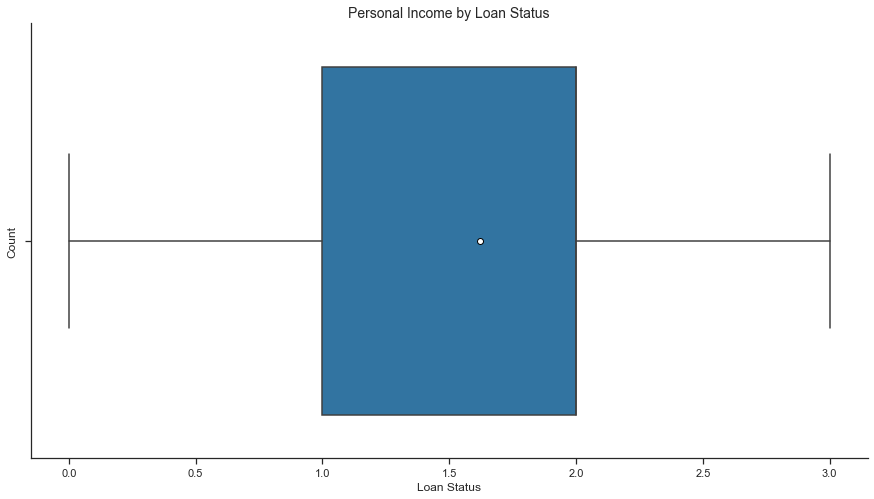

In [25]:
plt.figure(figsize=(15,8))

ax1 = sns.boxplot(data=df_features, x='h1n1_concern', showmeans=True, 
                 meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"})
ax1.set_title('Personal Income by Loan Status', fontsize=14)
ax1.set_xlabel('Loan Status')
ax1.set_ylabel('Count')

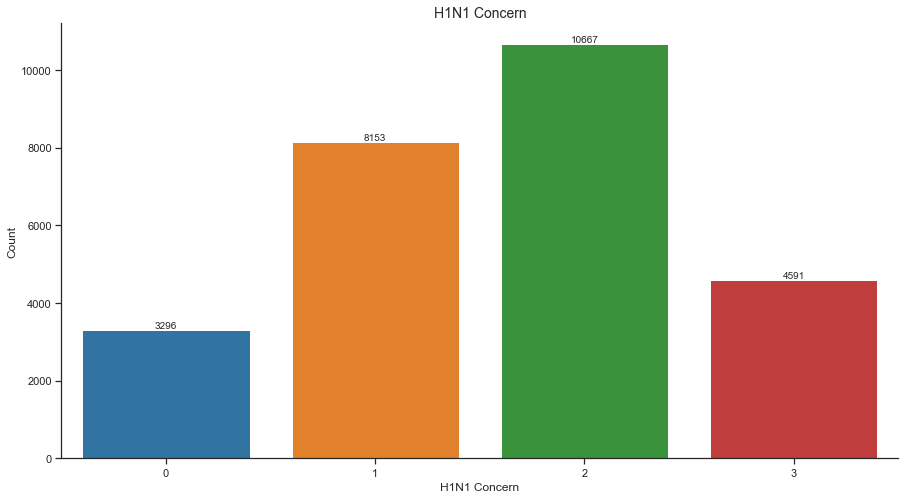

In [26]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='h1n1_concern')
ax.set_title("H1N1 Concern", fontsize=14)
ax.set_xlabel('H1N1 Concern')
ax.set_xticklabels([0,1,2,3])
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

Categorical

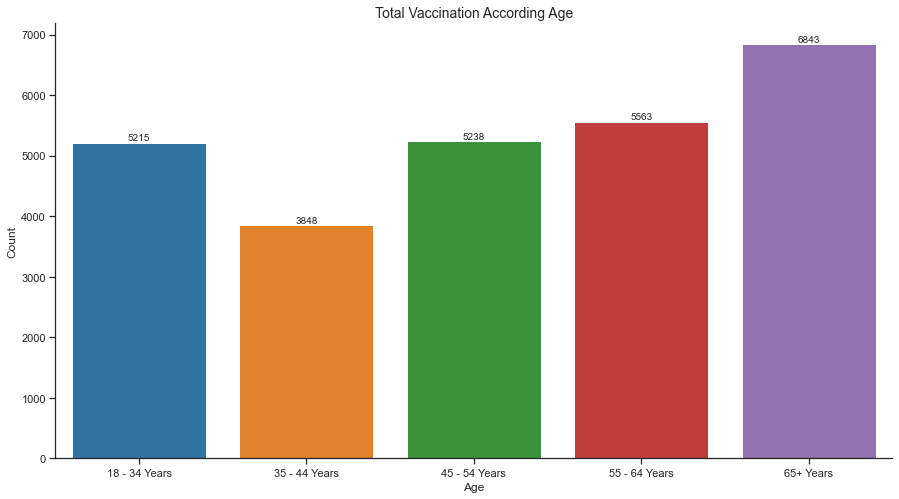

In [27]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='age_group', 
                   order=['18 - 34 Years','35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years'])
ax.set_title("Total Vaccination According Age", fontsize=14)
ax.set_xlabel('Age')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

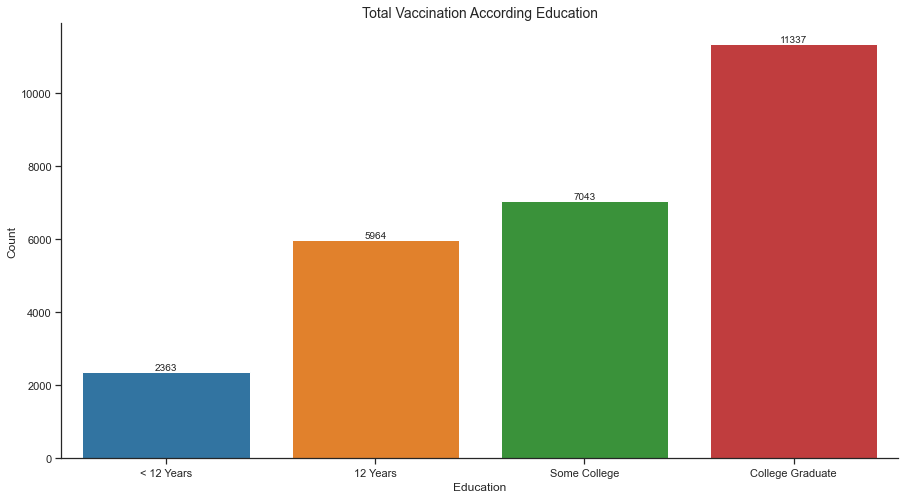

In [28]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='education',
                   order=['< 12 Years', '12 Years', 'Some College', 'College Graduate'])
ax.set_title("Total Vaccination According Education", fontsize=14)
ax.set_xlabel('Education')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

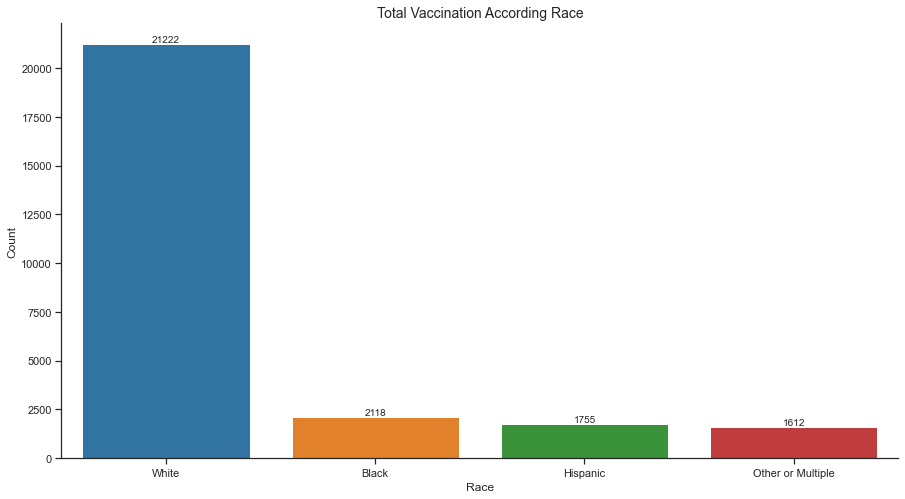

In [29]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='race', order=df_features['race'].value_counts().index)
ax.set_title("Total Vaccination According Race", fontsize=14)
ax.set_xlabel('Race')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

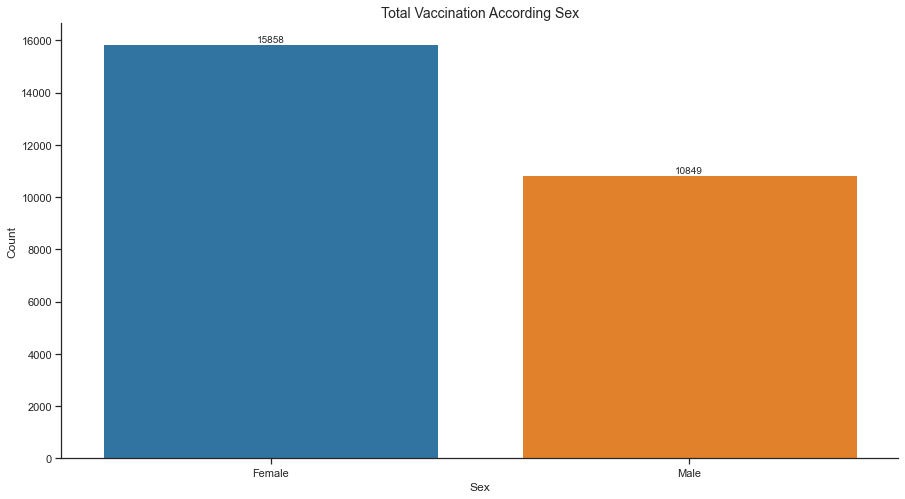

In [30]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='sex', order=df_features['sex'].value_counts().index)
ax.set_title("Total Vaccination According Sex", fontsize=14)
ax.set_xlabel('Sex')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

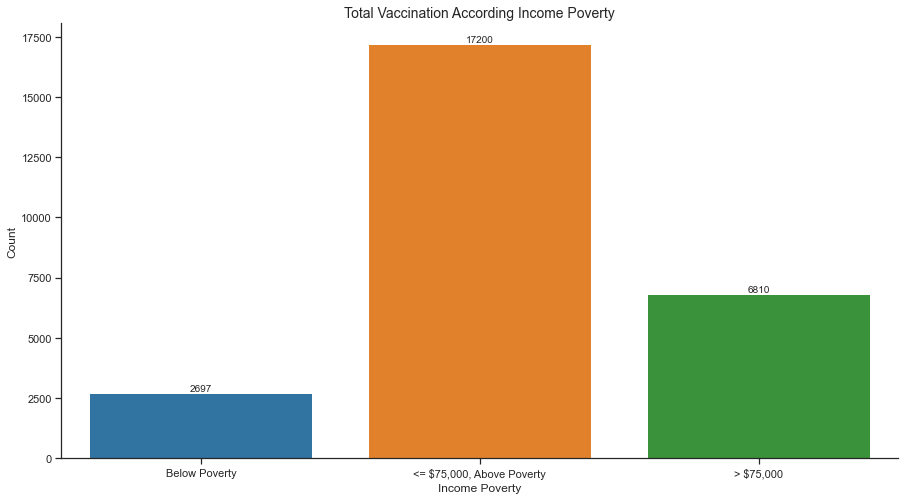

In [31]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='income_poverty', order=['Below Poverty', '<= $75,000, Above Poverty', '> $75,000'])
ax.set_title("Total Vaccination According Income Poverty", fontsize=14)
ax.set_xlabel('Income Poverty')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

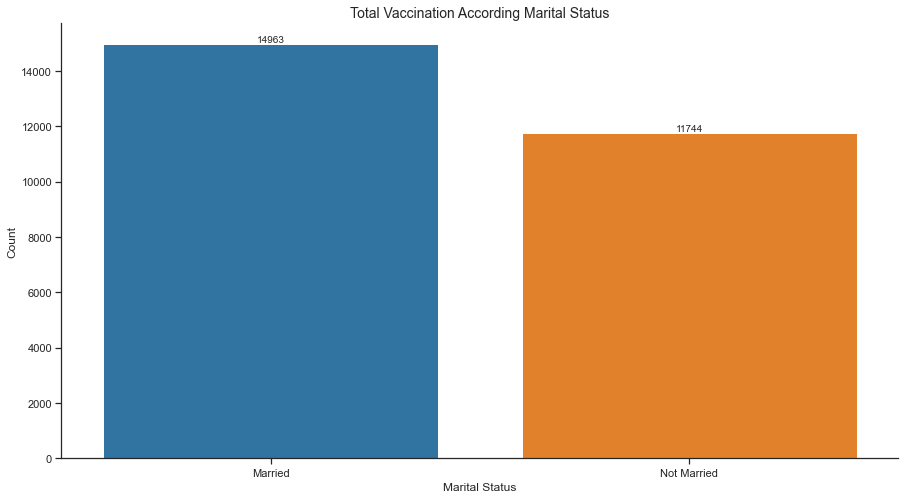

In [32]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='marital_status', order=df_features['marital_status'].value_counts().index)
ax.set_title("Total Vaccination According Marital Status", fontsize=14)
ax.set_xlabel('Marital Status')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

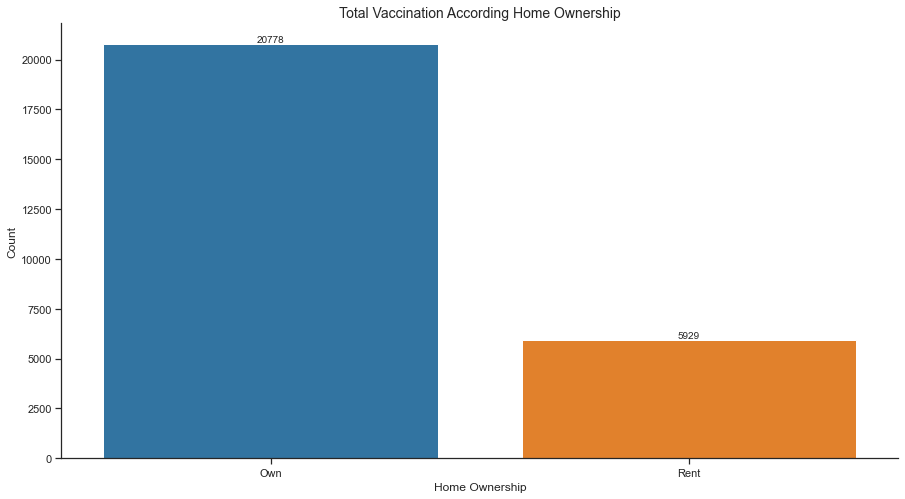

In [33]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='rent_or_own', order=df_features['rent_or_own'].value_counts().index)
ax.set_title("Total Vaccination According Home Ownership", fontsize=14)
ax.set_xlabel('Home Ownership')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

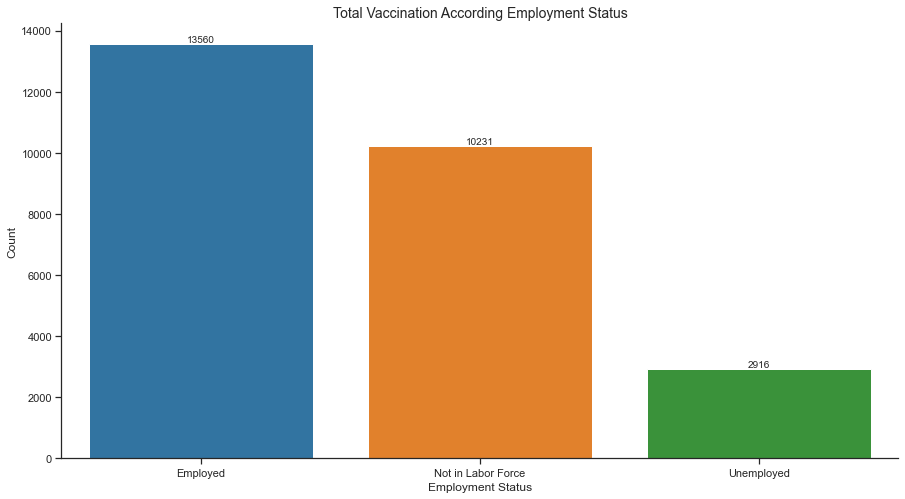

In [34]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='employment_status', order=df_features['employment_status'].value_counts().index)
ax.set_title("Total Vaccination According Employment Status", fontsize=14)
ax.set_xlabel('Employment Status')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

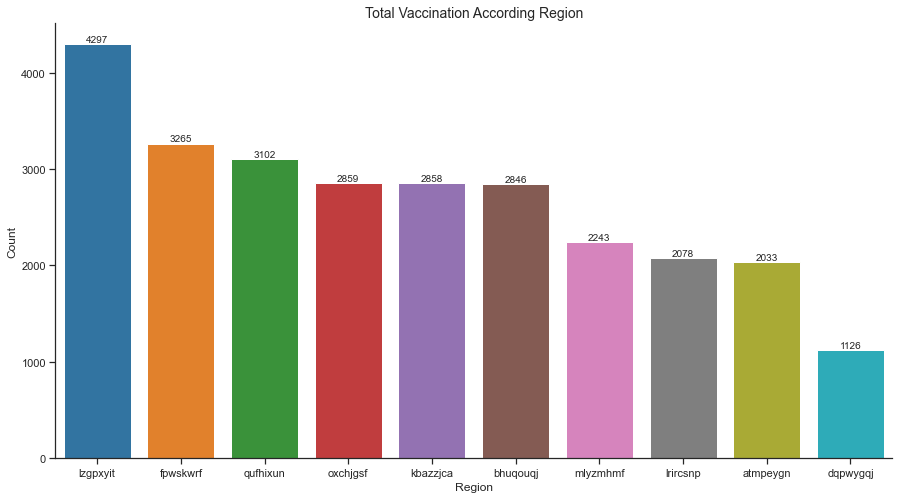

In [35]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='hhs_geo_region', order=df_features['hhs_geo_region'].value_counts().index)
ax.set_title("Total Vaccination According Region", fontsize=14)
ax.set_xlabel('Region')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

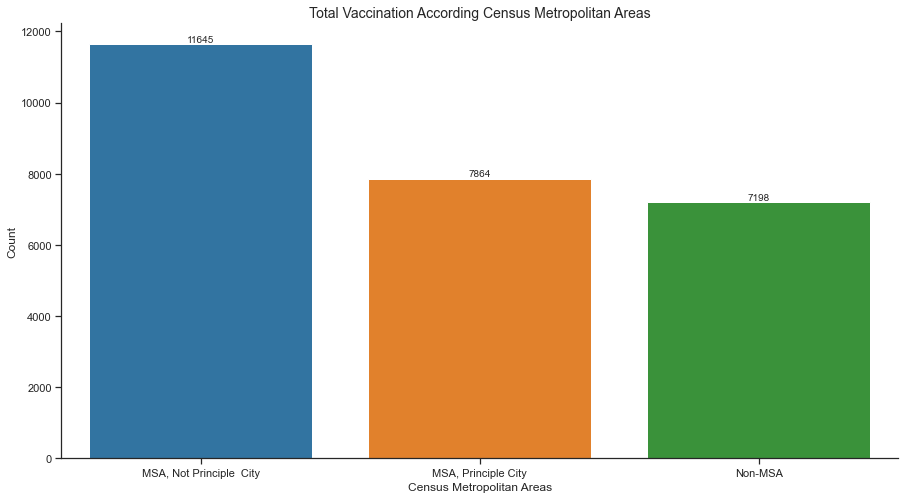

In [36]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='census_msa', order=df_features['census_msa'].value_counts().index)
ax.set_title("Total Vaccination According Census Metropolitan Areas", fontsize=14)
ax.set_xlabel('Census Metropolitan Areas')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

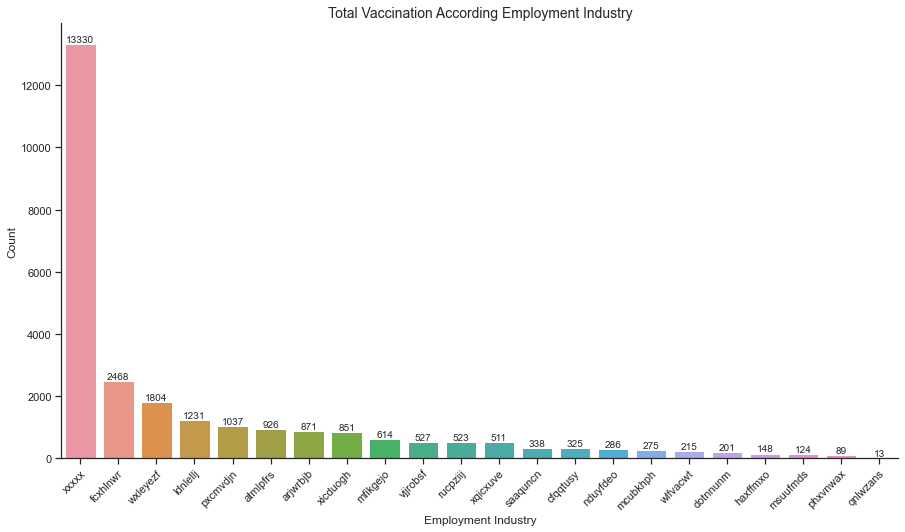

In [37]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='employment_industry', order=df_features['employment_industry'].value_counts().index)
ax.set_title("Total Vaccination According Employment Industry", fontsize=14)
ax.set_xlabel('Employment Industry')
ax.set_xticklabels(df_features['employment_industry'].value_counts().index, rotation=45, ha='right', rotation_mode='anchor')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

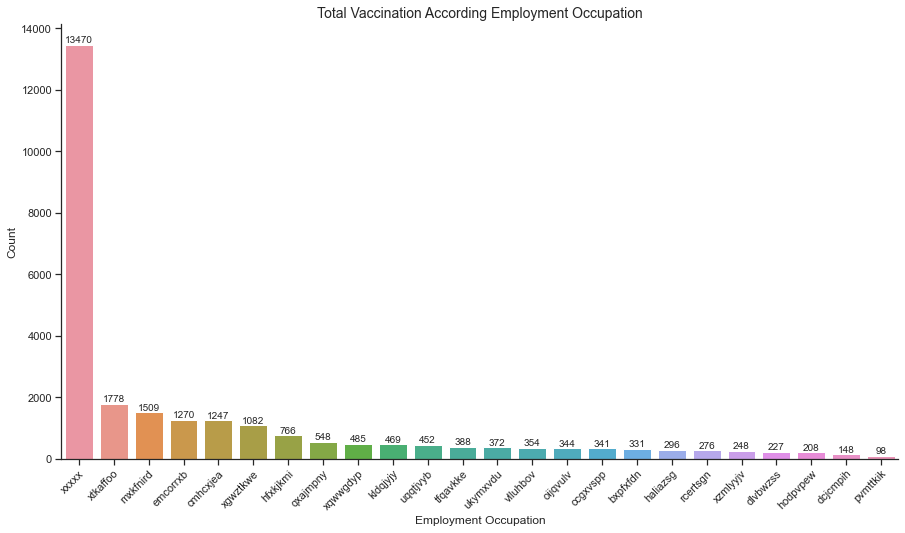

In [38]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=df_features, x='employment_occupation', order=df_features['employment_occupation'].value_counts().index)
ax.set_title("Total Vaccination According Employment Occupation", fontsize=14)
ax.set_xlabel('Employment Occupation')
ax.set_xticklabels(df_features['employment_occupation'].value_counts().index, rotation=45, ha='right', rotation_mode='anchor')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

In [39]:
df_features.select_dtypes(include=['object'])

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,xxxxx,xxxxx
1,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",pxcmvdjn,xgwztkwe
2,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",rucpziij,xtkaffoo
3,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",xxxxx,xxxxx
4,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...
26702,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,xxxxx,xxxxx
26703,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",fcxhlnwr,cmhcxjea
26704,55 - 64 Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Unemployed,lzgpxyit,"MSA, Not Principle City",xxxxx,xxxxx
26705,18 - 34 Years,Some College,Hispanic,Female,"<= $75,000, Above Poverty",Married,Rent,Employed,lrircsnp,Non-MSA,fcxhlnwr,haliazsg


## Modelling

### Catboost

In [178]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

#### Feature Selection

In [179]:
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
categorical_cols = X_train.select_dtypes('object').columns

ct = ColumnTransformer(
    [('ordinal', oe(), categorical_cols)],
    remainder='passthrough')

all_cols = X_train.columns

In [26]:
sfs1 = SFS(CatBoostClassifier(n_estimators=100, verbose=False), 
           k_features=X_train.shape[1], 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=5)

##### h1n1 Vaccines

In [27]:
sfs1 = sfs1.fit(ct.fit_transform(X_train), np.array(y_train.h1n1_vaccine).ravel())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  1.9min finished

[2023-05-02 11:06:11] Features: 1/36 -- score: 0.7043853654633565[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  2.0min finished

[2023-05-02 11:08:13] Features: 2/36 -- score: 0.7808224267946133[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:  1.9min finished

[2023-05-02 11:10:06] Features: 3/36 -- score: 0.8131991897550901[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [30]:
sfdf1 = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
sfdf1

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(29,)","[0.7050533756293852, 0.7081647888131812, 0.717...",0.704385,"(29,)",0.014763,0.011486,0.005743
2,"(22, 29)","[0.7764641666066844, 0.7793877435709093, 0.787...",0.780822,"(22, 29)",0.010571,0.008225,0.004112
3,"(22, 28, 29)","[0.8087429692239669, 0.8107038504771468, 0.822...",0.813199,"(22, 28, 29)",0.01,0.007781,0.00389
4,"(11, 22, 28, 29)","[0.8197961974684064, 0.8193333299089368, 0.829...",0.822531,"(11, 22, 28, 29)",0.010156,0.007902,0.003951
5,"(11, 22, 26, 28, 29)","[0.8184630920676051, 0.8208678876352744, 0.835...",0.824818,"(11, 22, 26, 28, 29)",0.009945,0.007738,0.003869
6,"(11, 22, 23, 26, 28, 29)","[0.8201447371578012, 0.822818081498927, 0.8378...",0.826754,"(11, 22, 23, 26, 28, 29)",0.009854,0.007667,0.003833
7,"(0, 11, 22, 23, 26, 28, 29)","[0.8215658879257455, 0.8241865559901685, 0.839...",0.828601,"(0, 11, 22, 23, 26, 28, 29)",0.010129,0.00788,0.00394
8,"(0, 11, 22, 23, 26, 28, 29, 31)","[0.823869634588162, 0.8242736640786789, 0.8404...",0.830119,"(0, 11, 22, 23, 26, 28, 29, 31)",0.010611,0.008256,0.004128
9,"(0, 11, 14, 22, 23, 26, 28, 29, 31)","[0.8230506627181211, 0.8265162158020493, 0.841...",0.830743,"(0, 11, 14, 22, 23, 26, 28, 29, 31)",0.010568,0.008222,0.004111
10,"(0, 1, 11, 14, 22, 23, 26, 28, 29, 31)","[0.8242318845050436, 0.8311644061368612, 0.843...",0.83171,"(0, 1, 11, 14, 22, 23, 26, 28, 29, 31)",0.010534,0.008196,0.004098


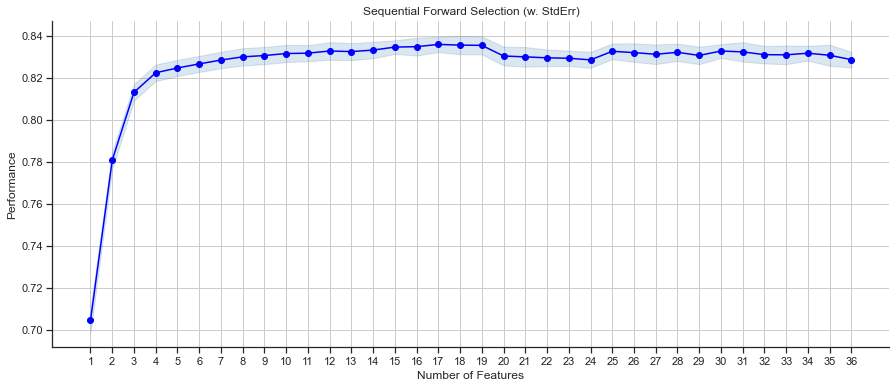

In [31]:
fig = plot_sfs(sfs1.get_metric_dict(), kind='std_err', figsize=(15,6))

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [33]:
print(sfdf1.loc[17, 'feature_idx'])

(0, 1, 3, 5, 11, 13, 14, 15, 22, 23, 25, 26, 27, 28, 29, 30, 31)


In [180]:
selected_columns_1 = [all_cols[i] for i in 
                     list((0, 2, 4, 10, 12, 13, 14, 21, 22, 24, 25, 26, 27, 28, 29, 30))]

In [181]:
selected_columns_1

['h1n1_concern',
 'behavioral_antiviral_meds',
 'behavioral_face_mask',
 'doctor_recc_seasonal',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'age_group',
 'education',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa']

##### Seasonal Flu Vaccines

In [ ]:
sfs2 = SFS(CatBoostClassifier(n_estimators=100, verbose=False), 
           k_features=X_train.shape[1], 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='roc_auc',
           cv=5)

In [ ]:
sfs2 = sfs2.fit(ct.fit_transform(X_train), np.array(y_train.seasonal_vaccine).ravel())

In [ ]:
sfdf2 = pd.DataFrame.from_dict(sfs2.get_metric_dict()).T
sfdf2

In [ ]:
fig = plot_sfs(sfs2.get_metric_dict(), kind='std_err', figsize=(15,6))

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [182]:
selected_columns_2 = [all_cols[i] for i in 
                     list((1, 3, 9, 13, 20, 21, 22, 23, 25, 26, 28, 29, 30, 31, 32, 34))]

In [183]:
selected_columns_2

['h1n1_knowledge',
 'behavioral_avoidance',
 'doctor_recc_h1n1',
 'health_worker',
 'opinion_seas_sick_from_vacc',
 'age_group',
 'education',
 'race',
 'income_poverty',
 'marital_status',
 'employment_status',
 'hhs_geo_region',
 'census_msa',
 'household_adults',
 'household_children',
 'employment_occupation']

### Model Optimization

In [273]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

In [275]:
categorical_features_indices = np.where(X_train[selected_columns_1].dtypes != float)[0]

train_dataset = Pool(data = X_train[selected_columns_1],
                     label = y_train.h1n1_vaccine,
                     cat_features = categorical_features_indices)

In [276]:
def objective(trial):
    param = {
        'iterations':trial.suggest_categorical('iterations', [100,200,300,500,1000,1200,1500]),
        'learning_rate':trial.suggest_float("learning_rate", 0.001, 0.3),
        'random_strength':trial.suggest_int("random_strength", 1,10),
        'bagging_temperature':trial.suggest_int("bagging_temperature", 0,10),
        'max_bin':trial.suggest_categorical('max_bin', [4,5,6,8,10,20,30]),
        'grow_policy':trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf':trial.suggest_int("min_data_in_leaf", 1,10),
        'od_type' : "Iter",
        'od_wait' : 100,
        "depth": trial.suggest_int("max_depth", 2,10),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),
        'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
        'custom_metric' : ['AUC'],
        "loss_function": "Logloss",
        'auto_class_weights':trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
        }

    scores = cv(train_dataset,
            param,
            fold_count=5, 
            early_stopping_rounds=10,         
            plot=False, verbose=False)

    return scores['test-AUC-mean'].max()

In [277]:
sampler = optuna.samplers.TPESampler(seed=5) 

study = optuna.create_study(direction="maximize", sampler=sampler)

study.optimize(objective, n_trials=100)

[I 2023-05-02 16:34:42,384] A new study created in memory with name: no-name-30e2fb7b-d518-4ddd-b028-792a1968563e


Training on fold [0/5]

bestTest = 0.5163244071
bestIteration = 54

Training on fold [1/5]

bestTest = 0.4894476582
bestIteration = 54

Training on fold [2/5]

bestTest = 0.5040489857
bestIteration = 78

Training on fold [3/5]

bestTest = 0.5008755086
bestIteration = 77

Training on fold [4/5]


[W 2023-05-02 16:35:00,885] Trial 0 failed with parameters: {'iterations': 500, 'learning_rate': 0.15600697837401004, 'random_strength': 3, 'bagging_temperature': 2, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 6, 'max_depth': 4, 'l2_leaf_reg': 7.028437810203034e-06, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "c:\Users\acer\AppData\Local\Programs\Python\Python39\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\acer\AppData\Local\Temp/ipykernel_14788/3241816886.py", line 20, in objective
    scores = cv(train_dataset,
  File "c:\Users\acer\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py", line 6650, in cv
    return _cv(params, pool, fold_count, inverted, partition_random_seed, shuffle, stratified,
  File "_catboost.pyx", line 5495, in _catboost._cv
  File "_cat

KeyboardInterrupt: 

In [60]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.7053192070985018
  Params: 
    iterations=300,
    learning_rate=0.12106040861337103,
    random_strength=6,
    bagging_temperature=3,
    max_bin=5,
    grow_policy=SymmetricTree,
    min_data_in_leaf=5,
    max_depth=2,
    l2_leaf_reg=1.1608395521145512e-08,
    one_hot_max_size=10,
    auto_class_weights=SqrtBalanced,


In [92]:
categorical_features_indices = np.where(X_train[selected_columns_2].dtypes != float)[0]

train_dataset_se = Pool(data = X_train[selected_columns_2],
                     label = y_train.seasonal_vaccine,
                     cat_features = categorical_features_indices)

In [62]:
def objective2(trial):
    param = {
        'iterations' : trial.suggest_categorical('iterations', [100,200,300,500,1000,1200,1500]),
        'learning_rate' : trial.suggest_float("learning_rate", 0.001, 0.3),
        'random_strength' : trial.suggest_int("random_strength", 1,10),
        'bagging_temperature' : trial.suggest_int("bagging_temperature", 0,10),
        'max_bin' : trial.suggest_categorical('max_bin', [4,5,6,8,10,20,30]),
        'grow_policy' : trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf' : trial.suggest_int("min_data_in_leaf", 1,10),
        'od_type' : "Iter",
        'od_wait' : 100,
        "depth": trial.suggest_int("max_depth", 2,10),
        "l2_leaf_reg" : trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),
        'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
        'custom_metric' : ['AUC'],
        "loss_function" : "Logloss",
        'auto_class_weights' : trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
        }

    scores = cv(train_dataset_se,
            param,
            fold_count=5, 
            early_stopping_rounds=10,         
            plot=False, verbose=False) 

    return scores['test-AUC-mean'].max()

In [ ]:
study2 = optuna.create_study(direction="maximize", sampler=sampler)
study2.optimize(objective2, n_trials=100)

In [66]:
print("Number of finished trials: {}".format(len(study2.trials)))
print("Best trial:")
trial2 = study2.best_trial
print("  Value: {}".format(trial2.value))
print("  Params: ")
for key, value in trial2.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.7453732520759334
  Params: 
    iterations=500,
    learning_rate=0.030779255514630056,
    random_strength=7,
    bagging_temperature=9,
    max_bin=4,
    grow_policy=Depthwise,
    min_data_in_leaf=2,
    max_depth=4,
    l2_leaf_reg=0.4633414715926186,
    one_hot_max_size=1024,
    auto_class_weights=SqrtBalanced,


### Final Model

In [241]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=5)

In [242]:
categorical_features_indices_h1n1 = np.where(X_train[selected_columns_1].dtypes == object)[0]
categorical_features_indices_flu = np.where(X_train[selected_columns_2].dtypes == object)[0]

model_h1n1 = CatBoostClassifier(verbose=False, cat_features=categorical_features_indices_h1n1, 
                                    **trial.params)
model_flu = CatBoostClassifier(verbose=False, cat_features=categorical_features_indices_flu, 
                                    **trial2.params)

In [246]:
model_h1n1.fit(X_train[selected_columns_1], y_train.h1n1_vaccine)
model_flu.fit(X_train[selected_columns_2], y_train.seasonal_vaccine)

pred_h1n1 = model_h1n1.predict_proba(X_test[selected_columns_1])
pred_flu = model_flu.predict_proba(X_test[selected_columns_2])

In [247]:
pred_h1n1 = pred_h1n1[:,1].reshape(-1,1)
pred_flu = pred_flu[:,1].reshape(-1,1)

In [250]:
roc_auc_score(y_test, np.hstack((pred_h1n1, pred_flu)))

0.7204544664285519

In [260]:
categorical_features_indices_h1n1 = np.where(X_train[selected_columns_1].dtypes == object)[0]
categorical_features_indices_flu = np.where(X_train[selected_columns_2].dtypes == object)[0]

f_model_h1n1 = CatBoostClassifier(verbose=False, cat_features=categorical_features_indices_h1n1, 
                                    **trial.params)
f_model_flu = CatBoostClassifier(verbose=False, cat_features=categorical_features_indices_flu, 
                                    **trial2.params)

f_model_h1n1.fit(X_train[selected_columns_1], y_train.h1n1_vaccine)
predictions_h1n1 = f_model_h1n1.predict_proba(df_test_features[selected_columns_1])
predictions_h1n1 = predictions_h1n1[:,1].reshape(-1,1)

f_model_flu.fit(X_train[selected_columns_2], y_train.seasonal_vaccine)
predictions_flu = f_model_flu.predict_proba(df_test_features[selected_columns_2])
predictions_flu = predictions_flu[:,1].reshape(-1,1)

In [262]:
len(predictions_flu)

26708

## Submission

In [263]:
submission_df

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.5,0.7
26708,0.5,0.7
26709,0.5,0.7
26710,0.5,0.7
26711,0.5,0.7
...,...,...
53410,0.5,0.7
53411,0.5,0.7
53412,0.5,0.7


In [265]:
df_test_features

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"> $75,000",Not Married,Rent,Not in Labor Force,mlyzmhmf,"MSA, Not Principle City",1.0,0.0,atmlpfrs,hfxkjkmi
1,26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,Non-MSA,3.0,0.0,atmlpfrs,xqwwgdyp
2,26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,"> $75,000",Married,Own,Employed,lrircsnp,Non-MSA,1.0,0.0,nduyfdeo,pvmttkik
3,26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,0.0,xxxxx,xxxxx
4,26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,lzgpxyit,Non-MSA,0.0,1.0,fcxhlnwr,mxkfnird
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26703,53410,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,dqpwygqj,"MSA, Principle City",1.0,1.0,xxxxx,xxxxx
26704,53411,3.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,Below Poverty,Married,Rent,Unemployed,qufhixun,Non-MSA,1.0,3.0,fcxhlnwr,vlluhbov
26705,53412,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,xxxxx,xxxxx
26706,53413,3.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,bhuqouqj,"MSA, Not Principle City",1.0,0.0,xxxxx,xxxxx


In [271]:
submission_df = pd.read_csv("data/submission_format.csv", 
                            index_col="respondent_id")

# np.testing.assert_array_equal(df_test_features.index.values, 
#                               submission_df.index.values)

# Save predictions to submission data frame
submission_df["h1n1_vaccine"] = predictions_h1n1
submission_df["seasonal_vaccine"] = predictions_flu

submission_df.head()

AssertionError: 
Arrays are not equal

Mismatched elements: 26708 / 26708 (100%)
Max absolute difference: 26707
Max relative difference: 1.
 x: array([    0,     1,     2, ..., 26705, 26706, 26707], dtype=int64)
 y: array([26707, 26708, 26709, ..., 53412, 53413, 53414], dtype=int64)

In [267]:
submission_df

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.307545,0.336807
26708,0.141417,0.166629
26709,0.428345,0.442528
26710,0.379383,0.749263
26711,0.376715,0.308003
...,...,...
53410,0.324368,0.576578
53411,0.424840,0.312166
53412,0.138653,0.171714


In [270]:
date = pd.Timestamp.now().strftime(format='%Y-%m-%d_%H-%M_')
submission_df.to_csv(f'predictions/{date}submssion_catboost_optunacvi.csv', index=True)